<h1 style="font-family: Verdana; font-size: 28px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;"><center><br>[WSI Preprocessing] 👀: Fast Tiling + Tissue Segmentation </center></h1>
                                                      
<center><img src = "https://drive.google.com/uc?id=1pbIvjTlhGywfhiMTqcsdOB5LSHlklM90"/></center>   

<h5 style="text-align: center; font-family: Verdana; font-size: 12px; font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color: black; background-color: #ffffff;">CREATED BY: NGHI HUYNH</h5>

<p id="toc"></p>
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;" role="tab" aria-controls="home"><center><br>CONTENTS</center></h2>

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 16px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: black; background-color: #ffffff;"><a href="#preprocessing">0&nbsp;&nbsp;&nbsp;&nbsp;WHY DATA PREPROCESSING?</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 16px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: black; background-color: #ffffff;"><a href="#scaling">1&nbsp;&nbsp;&nbsp;&nbsp;IMAGE SCALING</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 16px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: black; background-color: #ffffff;"><a href="#segmentation">2&nbsp;&nbsp;&nbsp;&nbsp;TISSUE SEGMENTATION</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 16px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: black; background-color: #ffffff;"><a href="#retrieval">3&nbsp;&nbsp;&nbsp;&nbsp;FAST TILING + TILE SELECTION + RETRIEVAL</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 16px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: black; background-color: #ffffff;"><a href="#conclusion">4&nbsp;&nbsp;&nbsp;&nbsp;CONCLUSION</a></h3>

---



<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:#F08080; border:0; color:black' role="tab" aria-controls="home"><center><br>If you find this notebook useful, do give me an upvote, it motivates me a lot.<br><br> This notebook is still a work in progress. Keep checking for further developments!😊</center></h3>

<a id="preprocessing"></a>

<h2 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;" id="preprocessing"><left><br>&nbsp0. WHY DATA PREPROCESSING? <a href="#toc">&#10514;</a><br></left> </h2>

## Problems:
* **WSIs with high resolution**: 3000x3000 for training data (HPA images) -> unable to fit into any SOTA/contemporary deep learning models in one go
* **Small training data**: 351 images -> easily overfit
* **Large portion of background, shadows, artefacts, etc**: -> add little to no information to the learning process, waste computation resources, and can cause severe detrimental effects on deep learning models
    
=> **Data preprocessing** is a crucial process in addressing these problems. Data preprocessing can increase the quality of the image data and facilitate our model training.  In brief, we will scale down whole-slide images (WSIs), apply filters to these scaled-down images for tissue segmentation, break the slides into tiles, select tiles containing tissue regions, and then retrieve and save those tiles into folders based on organs.

## Data Preprocessing:
### Steps:

**1. Image Scaling**: scale down whole-slide images (WSIs) in the training data from 3000x3000 to 1024x1024 resolution

**2. Tissue Segmentation**: identify tissue regions in scaled-down images using the following foreground/background filtering approaches:
* [Simple Thresholding](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html)
* [Otsu's Binarization](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html)
* [Triangle Binarization](https://subscription.packtpub.com/book/data/9781789344912/9/ch09lvl1sec80/the-triangle-binarization-algorithm)
    
**3. Fast Tiling + Tile Selection + Retrieval**: select tiles based on thresholds calculated from ***step 2***. Note that tile size should be large enough that feature relevant to the task are visible to the model to learn

[**References**: Apply filters for tissue segmentation](https://developer.ibm.com/articles/an-automatic-method-to-identify-tissues-from-big-whole-slide-images-pt2/)

<a id="scaling"></a>

<h2 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;" id="scaling"><left><br>&nbsp1. IMAGE SCALING <a href="#toc">&#10514;</a><br></left> </h2>

## Imports

In [1]:
import gc
import os
import cv2
import zipfile
import rasterio
import numpy as np
import math
import pandas as pd
from PIL import Image
import tifffile as tiff
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from rasterio.windows import Window
from torch.utils.data import Dataset

## Config

In [2]:
TRAIN_PATH = '../input/hubmap-organ-segmentation/train_images/'
train_df   = pd.read_csv('../input/hubmap-organ-segmentation/train.csv')
full_img_size = 3000

## Helper functions

In [3]:
# functions to convert encoding to mask and mask to encoding
# https://www.kaggle.com/paulorzp/rle-functions-run-length-encode-decode
def mask2rle(img): # encoder
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)): # decoder
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [4]:
# rescale to a desire img size
# keep in mide that the size needs to be large enough
# to keep all important features for model training
def rescale(img, mask, size=(1024,1024)):
    scaled_img = cv2.resize(img, size)
    scaled_mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
    return scaled_img, scaled_mask

In [5]:
# visualize scaled-down images + masks based on organ
def visualize(df, organ):
    tmp_df = df.loc[train_df['organ'] == organ].reset_index(drop=True)
    plt.figure(figsize=(16,4))
    for i in range(5):
        img  = tiff.imread(TRAIN_PATH + str(tmp_df['id'][i]) +'.tiff')
        mask = rle2mask(tmp_df['rle'][i], (full_img_size, full_img_size))
        scaled_img, scaled_mask = rescale(img, mask)
        plt.subplot(1,5,i+1)
        plt.imshow(scaled_img)
        plt.imshow(scaled_mask, cmap='seismic', alpha=0.4)
        plt.title('ID:'+ str(tmp_df['id'][i]))
    plt.suptitle(organ, fontsize=20)
    plt.tight_layout()

## Scaling + Visualization

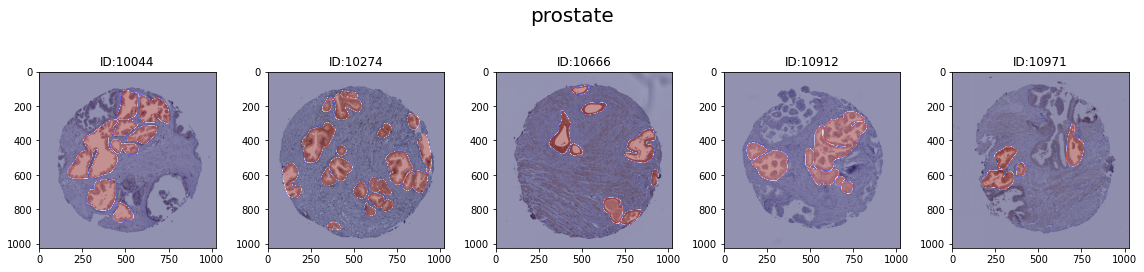

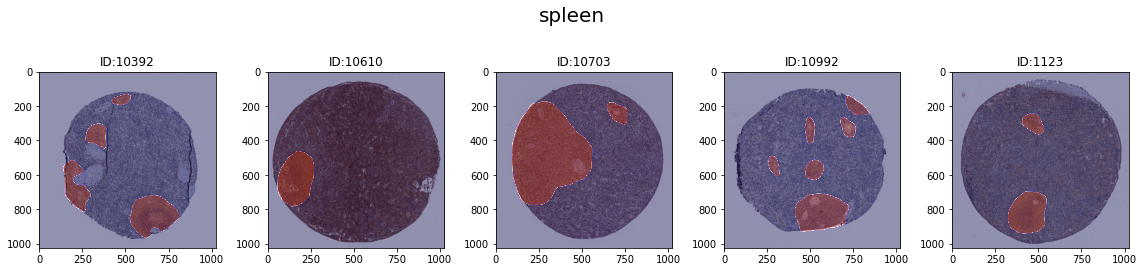

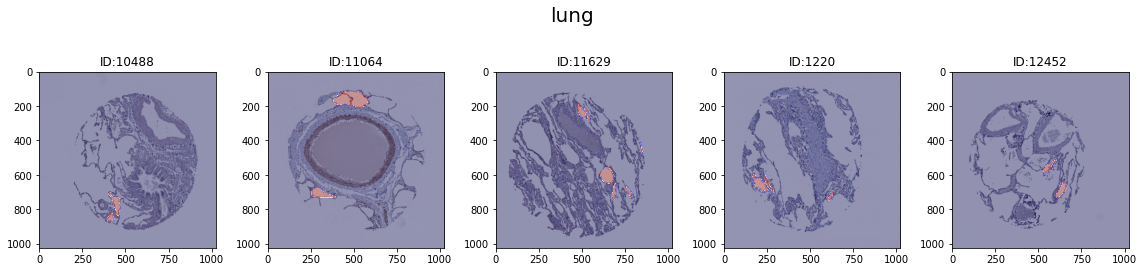

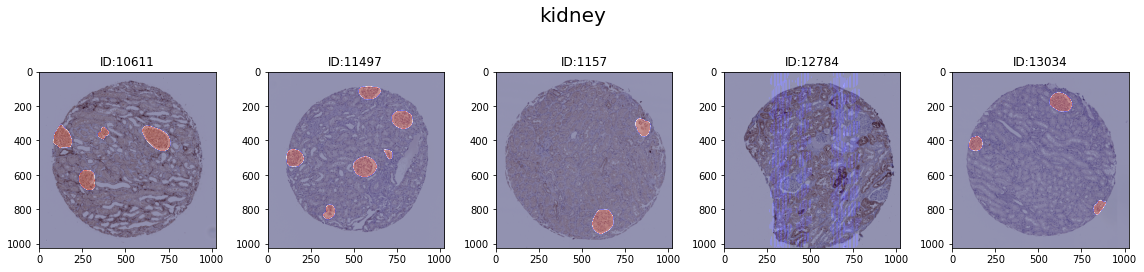

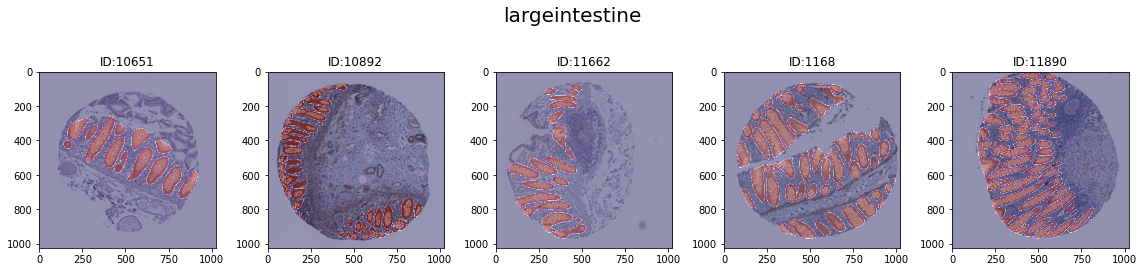

In [6]:
organs = train_df['organ'].unique()
for organ in organs:
    visualize(train_df, organ)
plt.show()

> #### *ID 12784 from kidney has no FTUs -> we need to thoroughly scan through all images to remove those faulted images if they exist*

<a id="segmentation"></a>

<h2 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;" id="segmentation"><left><br>&nbsp2. TISSUE SEGMENTATION <a href="#toc">&#10514;</a><br></left> </h2>

## Goal: 
Mask out non-tissue by setting non-tissue pixels to 0 for their red, green, and blue channels.

Conceptually and mathematically, it is often useful to have background values close to or equal to 0 (complement image)

Complement image: simply subtract each pixel value from the maximum pixel value supported by the class (class uint8, the max value of pixel can be 255) and store in the output image array. In the output image, dark areas become lighter and light areas become darker

## Foreground/Background Thresholding Techniques:
* [Otsu](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html): global image thresholding algorithm, applied to images which are bimodal, which means the image is having 2 peaks in the histogram
* [Triangle binarization](https://subscription.packtpub.com/book/data/9781789344912/9/ch09lvl1sec80/the-triangle-binarization-algorithm): a line is drawn from the highest bar to the end of the histogram. Then for choosing the optimal threshold, distance of each bar is calculated from the line, whichever is least becomes the threshold value


**Side Note**: [Understanding Histograms in Image Processing](https://towardsdatascience.com/histograms-in-image-processing-with-skimage-python-be5938962935)

## Helper Functions

In [7]:
def thresholding(img, method='otsu'):
    # convert to grayscale complement image
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_c = 255 - grayscale_img
    thres, thres_img = 0, img_c.copy()
    if method == 'otsu':
        thres, thres_img = cv2.threshold(img_c, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif method == 'triangle':
        thres, thres_img = cv2.threshold(img_c, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_TRIANGLE)
    return thres, thres_img, img_c

In [8]:
def histogram(img, thres_img, img_c, thres):
    """
    style: ['color', 'grayscale']
    """ 
    plt.figure(figsize=(15,15))
    
    plt.subplot(3,2,1)
    plt.imshow(img)
    plt.title('Original Image')
    
    plt.subplot(3,2,2)
    sns.histplot(img.ravel(), bins=np.arange(0,256), color='orange', alpha=0.5)
    sns.histplot(img[:,:,0].ravel(), bins=np.arange(0,256), color='red', alpha=0.5)
    sns.histplot(img[:,:,1].ravel(), bins=np.arange(0,256), color='Green', alpha=0.5)
    sns.histplot(img[:,:,2].ravel(), bins=np.arange(0,256), color='Blue', alpha=0.5)
    plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
    plt.ylim(0,0.3e6)
    plt.xlabel('Intensity value')
    plt.title('Color Histogram')
    
    plt.subplot(3,2,3)
    plt.imshow(img_c, cmap='gist_gray')
    plt.title('Complement Grayscale Image')
    
    plt.subplot(3,2,4)
    sns.histplot(img_c.ravel(), bins=np.arange(0,256))
    plt.axvline(thres, c='red', linestyle="--")
    plt.ylim(0,0.3e6)
    plt.xlabel('Intensity value')
    plt.title('Grayscale Complement Histogram')
    
    plt.subplot(3,2,5)
    plt.imshow(thres_img, cmap='gist_gray')
    plt.title('Thresholded Image')
    
    plt.subplot(3,2,6)
    sns.histplot(thres_img.ravel(), bins=np.arange(0,256))
    plt.axvline(thres, c='red', linestyle="--")
    plt.ylim(0,0.3e6)
    plt.xlabel('Intensity value')
    plt.title('Thresholded Histogram')
    
    plt.tight_layout()
    plt.show()

## Otsu's Binarization

In [9]:
img_test2 = tiff.imread('../input/hubmap-organ-segmentation/train_images/10666.tiff')

In [10]:
thres_otsu, thres_img, img_c = thresholding(img_test2, method='otsu')

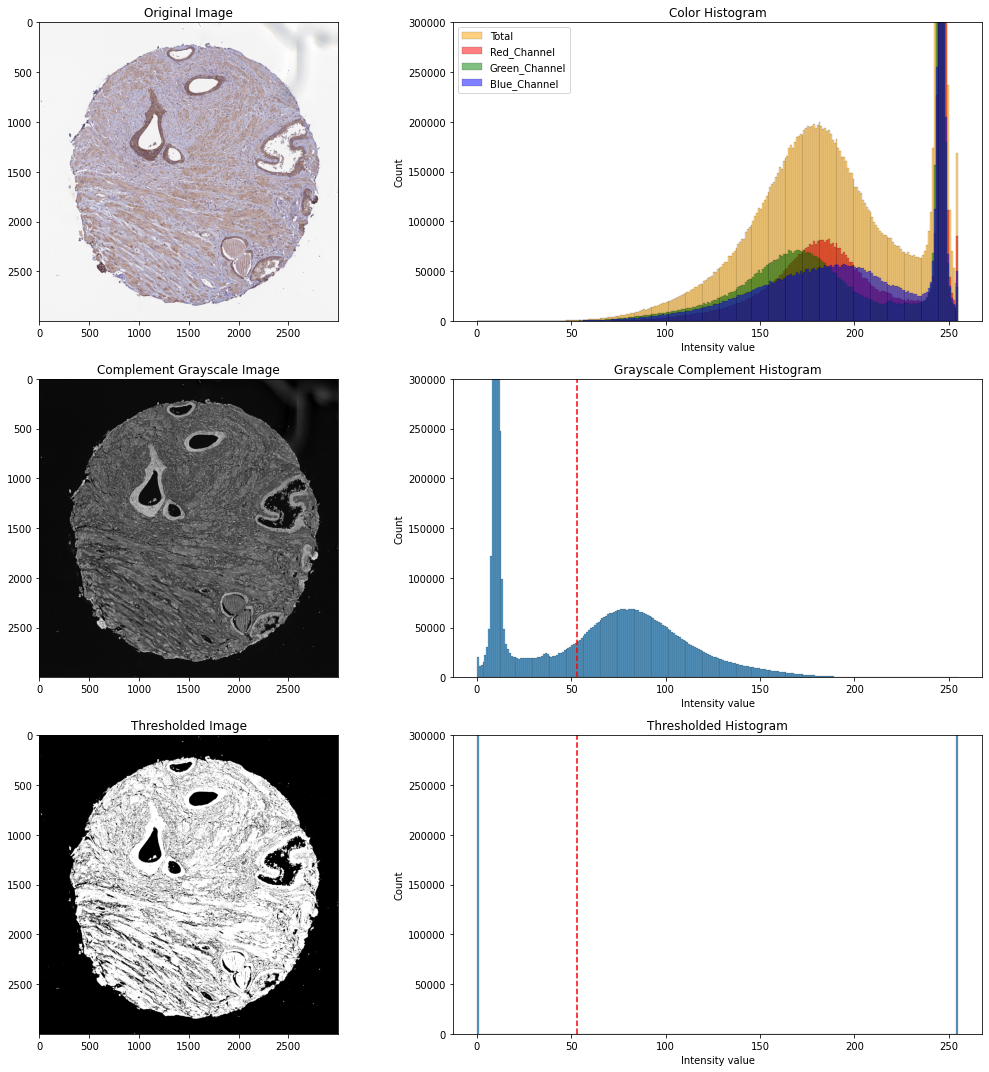

In [11]:
histogram(img_test2, thres_img, img_c, thres_otsu)

## Triangle Binarization

In [12]:
thres, thres_img, img_c = thresholding(img_test2, method='triangle')

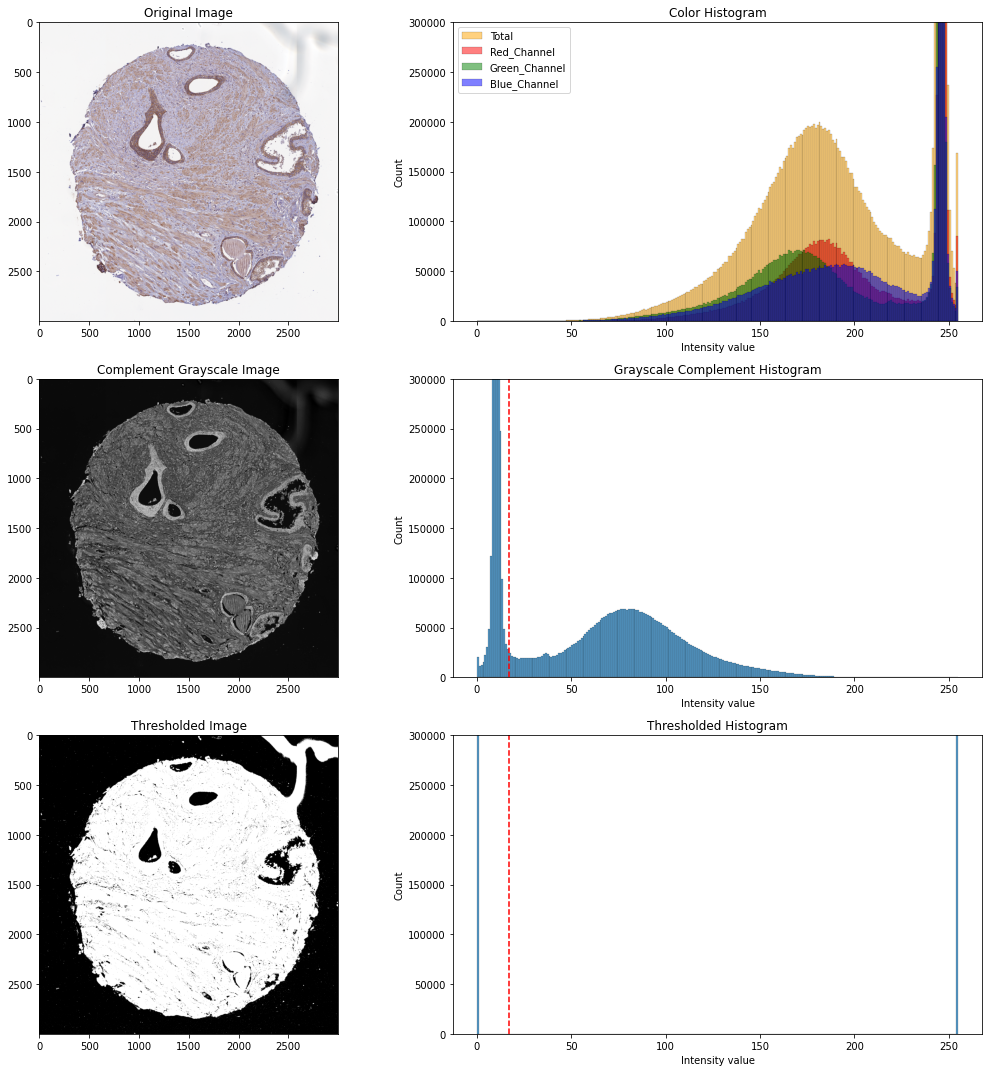

In [13]:
histogram(img_test2, thres_img, img_c, thres)

> #### *Otsu vs. Triangle binarization can only separate background and foreground but cannot detect artefacts. For example, Otsu treats lighter-colored tissue regions as background, whereas triangle binarization treats artefact as tissue regions. Thus, we need to dive deeper into these two thresholding techniques to have better tissue segmentation*

<a id="retrieval"></a>

<h2 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;" id="retrieval"><left><br>&nbsp3. FAST TILING + TILE SELECTION + RETRIEVAL <a href="#toc">&#10514;</a><br></left> </h2>

## Helper Functions

In [14]:
# adapted from: https://www.kaggle.com/code/analokamus/a-fast-tile-generation
def make_tiles(img, mask, tile_size=256):
    '''
    img: np.ndarray with dtype np.uint8 and shape (width, height, channel)
    mask: np.ndarray with dtype np.uint9 and shape (width, height)
    '''
    w_i, h_i, ch = img.shape
    w_m, h_m     = mask.shape
    
    pad0, pad1 = (tile_size - w_i%tile_size) % tile_size, (tile_size - h_i%tile_size) % tile_size
    
    padding_i = [[pad0//2, pad0-pad0//2], [pad1//2, pad1-pad1//2], [0, 0]]
    padding_m = [[pad0//2, pad0-pad0//2], [pad1//2, pad1-pad1//2]]
    
    img = np.pad(img, padding_i, mode='constant', constant_values=255)
    img = img.reshape(img.shape[0]//tile_size, tile_size, img.shape[1]//tile_size, tile_size, ch)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, tile_size, tile_size, ch)
    
    mask = np.pad(mask, padding_m, mode='constant', constant_values=255)
    mask = mask.reshape(mask.shape[0]//tile_size, tile_size, mask.shape[1]//tile_size, tile_size)
    mask = mask.transpose(0, 2, 1, 3).reshape(-1, tile_size, tile_size)
    
    num_tiles = len(mask)
    #     if len(img) < num_tiles: # pad images so that the output shape be the same
    #         padding = [[0, num_tiles-len(img)], [0, 0], [0, 0], [0, 0]]
    #         img = np.pad(img, padding, mode='constant', constant_values=255)
    #idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:num_tiles] # pick up Top N dark tiles
    #img = img[idxs]
    return img, mask

In [15]:
def visualize_tiles(img, mask, img_tiles, mask_tiles):
    plt.figure(figsize=(9.5,9.5))
    plt.imshow(img)
    plt.imshow(mask, cmap='seismic', alpha=0.4)
    plt.title(f'Scaled Image + Mask\nImage Size: {img.shape}')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    for i, imgs in enumerate(img_tiles):
        plt.figure(figsize=(7.65,7.70))
        num_tiles, size, _, _ = imgs.shape
        rows = cols = int(math.sqrt(num_tiles))
        for j, img_crop in tqdm(enumerate(imgs)):
            plt.subplot(rows,cols,j+1)
            plt.imshow(img_crop)
            plt.imshow(mask_tiles[i][j], cmap='seismic',alpha=0.4)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        plt.suptitle(f'Image + Mask \nNum Tiles: {len(imgs)}\nTile Size: {img_crop.shape}')
        plt.tight_layout()
        plt.show()
    plt.show()

In [16]:
# visualize selected tiles
def tile_selection(img, mask, thres, tile_size=256):
    img_tiles, mask_tiles = make_tiles(img, mask, tile_size)
    num_tiles, size, _, _ = img_tiles.shape
    rows = cols = int(math.sqrt(num_tiles))
    plt.figure(figsize=(7.65,7.70))
    
    for i, img_crop in tqdm(enumerate(img_tiles)):
            plt.subplot(rows,cols,i+1)
            plt.imshow(img_crop)
            plt.imshow(mask_tiles[i], cmap='seismic',alpha=0.4)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
    plt.suptitle(f'Image + Mask \nNum Tiles: {len(img_tiles)}\nTile Size: {img_tiles[0].shape}')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(7.65,7.70))
    selected_tiles = 0
    for i, img_crop in tqdm(enumerate(img_tiles)):
        img_c = 255-img_crop # image complement
        plt.subplot(rows, cols, i+1)
        plt.xticks([])
        plt.yticks([])
        if img_c.mean() > thres: # pixel value mean greater threshold -> select tile 
            selected_tiles += 1
            plt.imshow(img_crop)
            plt.imshow(mask_tiles[i], cmap='seismic', alpha=0.4)
            plt.tight_layout()
    plt.suptitle(f'Num Tiles: {len(img_tiles)}\nNum Selected Tiles: {selected_tiles}\nThreshold: {thres}')
    plt.tight_layout()
    plt.show()

In [17]:
def tile_saving(ID, df, thres, img_folder, mask_folder, rescale_size=(1024,1024), tile_size=256):
    # load original img and mask
    img  = tiff.imread(TRAIN_PATH + str(ID) +'.tiff')
    mask = rle2mask(df.loc[df['id'] == ID].rle.values[0], (full_img_size, full_img_size))
    
    # rescale to 1024x1024
    scaled_img, scaled_mask = rescale(img, mask, size=rescale_size)
    
    # make tiles + select based on given threshold
    img_tiles, mask_tiles = make_tiles(scaled_img, scaled_mask, tile_size)
    for i, img_crop in tqdm(enumerate(img_tiles)):
        img_c = 255-img_crop # image complement
        if img_c.mean() > thres: # pixel value mean greater threshold -> select tile 
            cv2.imwrite(os.path.join(img_folder,f'{ID}_{i}.png'), img_crop)
            cv2.imwrite(os.path.join(mask_folder, f'{ID}_{i}.png'), mask_tiles[i])
    print('-------------Done------------')

## Tiling

In [18]:
# resize img, mask to 1024x1024 before tiling
ID = 10666
img = tiff.imread(f'../input/hubmap-organ-segmentation/train_images/{ID}.tiff')
mask = rle2mask(train_df.loc[train_df['id'] == ID].rle.values[0], (full_img_size, full_img_size))
scaled_img, scaled_mask = rescale(img, mask, size=(1024,1024))

In [19]:
%%time
img_tiles, mask_tiles = make_tiles(scaled_img, scaled_mask, tile_size=128)

CPU times: user 3.51 ms, sys: 0 ns, total: 3.51 ms
Wall time: 3.56 ms


In [20]:
img_tiles_256, mask_tiles_256 = make_tiles(scaled_img, scaled_mask, tile_size=256)

In [21]:
tiles = [img_tiles_256, img_tiles ]
masks = [mask_tiles_256, mask_tiles]

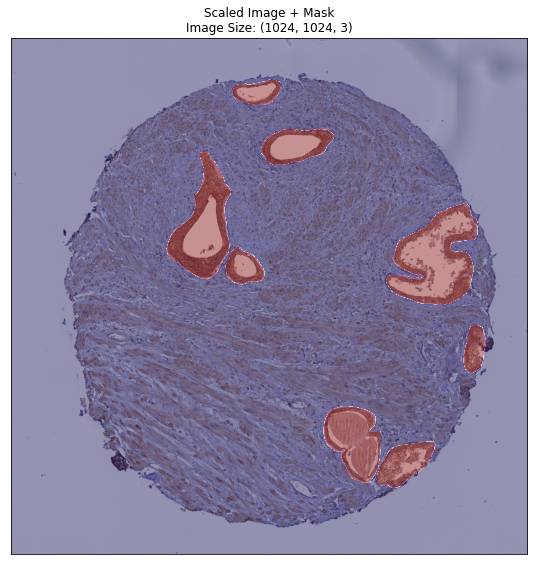

0it [00:00, ?it/s]

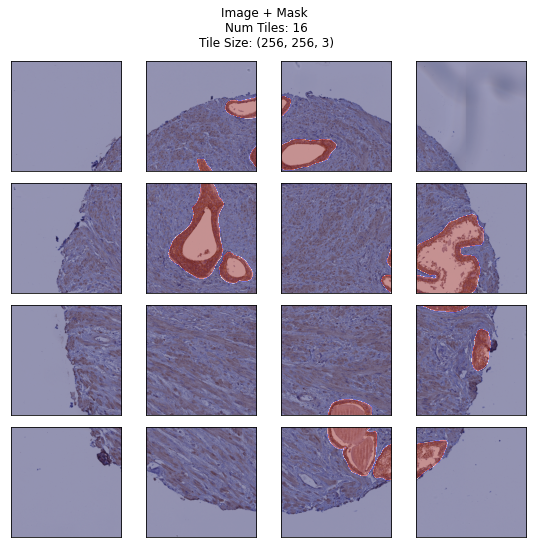

0it [00:00, ?it/s]

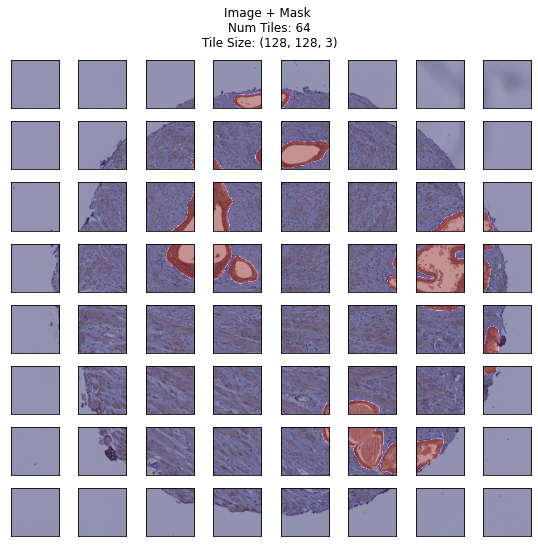

In [22]:
visualize_tiles(scaled_img, scaled_mask, tiles, masks)

> #### *There is a trade-off between different tile sizes. We can notice that a larger tile size contains more information about FTUs. In contrast, a smaller tile size leads to a larger number of tiles. However, many of these tiles only contain background or tissue regions with no FTUs. Thus, we need to be cautious when choosing tile size to yield a better result for training our model.*

## Tile Selection

Based on the thresholds from **section 2** (Otsu, or Triangle), we will select tiles that contain tissue regions and discard background tiles. Since image pixels are now separated into 2 clusters with intensity values 0 and 255 (black, white), tiles consist pixel values' mean greater than a given threshold are selected for further analysis. A tissue region is determined by thresholding the grayscale image complement in **section 2**.

0it [00:00, ?it/s]

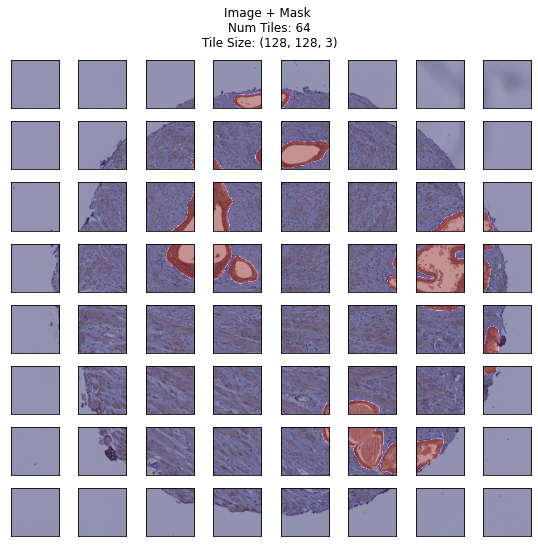

0it [00:00, ?it/s]

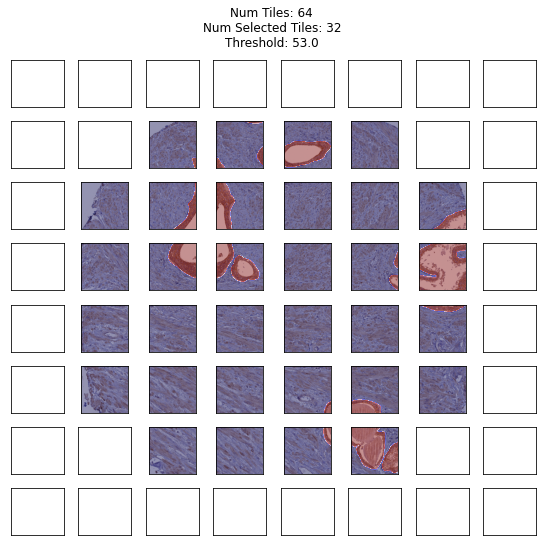

In [23]:
tile_selection(scaled_img, scaled_mask, thres_otsu, tile_size=128)

> #### *We can discard many unnecessary tiles such as background and artefacts by a simple thresholding technique. However, there are many tiles containing tissue regions without FTUs. We can work on this a bit more and obtain a suitable threshold to increase the quality of our image training data*

## Tile Saving

Let's save our selected image and mask tiles into the following folder structure:

```
train
├── image
└── mask  
```

In [24]:
!mkdir train train/image train/mask
img_folder  = './train/image'
mask_folder = './train/mask'

mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘train/image’: File exists
mkdir: cannot create directory ‘train/mask’: File exists


In [25]:
ID = 10666
tile_saving(ID, train_df, thres_otsu, img_folder, mask_folder, tile_size=128)

0it [00:00, ?it/s]

-------------Done------------


In [26]:
!zip -r train.zip train

updating: train/ (stored 0%)
updating: train/mask/ (stored 0%)
updating: train/mask/10666_10.png (deflated 50%)
updating: train/mask/10666_43.png (deflated 66%)
updating: train/mask/10666_51.png (deflated 66%)
updating: train/mask/10666_37.png (deflated 66%)
updating: train/mask/10666_22.png (deflated 23%)
updating: train/mask/10666_34.png (deflated 66%)
updating: train/mask/10666_17.png (deflated 66%)
updating: train/mask/10666_27.png (deflated 8%)
updating: train/mask/10666_50.png (deflated 66%)
updating: train/mask/10666_25.png (deflated 66%)
updating: train/mask/10666_53.png (deflated 14%)
updating: train/mask/10666_19.png (deflated 24%)
updating: train/mask/10666_11.png (deflated 29%)
updating: train/mask/10666_30.png (deflated 21%)
updating: train/mask/10666_28.png (deflated 66%)
updating: train/mask/10666_38.png (deflated 40%)
updating: train/mask/10666_35.png (deflated 66%)
updating: train/mask/10666_42.png (deflated 66%)
updating: train/mask/10666_26.png (deflated 12%)
updatin

## Sanity Check

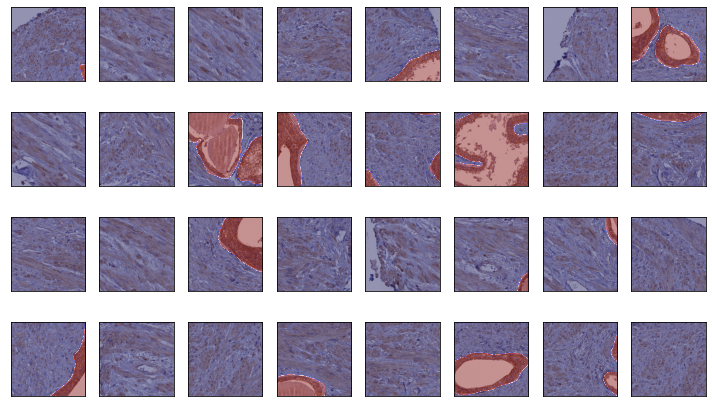

In [27]:
img_path = './train/image'
mask_path  = './train/mask'
for _, _, files in os.walk(img_path):
    plt.figure(figsize=(10,6))
    plt.subplots_adjust(left=0.5,
                        right=0.6,
                        top=0.6,
                        bottom=0.5
                       )
    for i, name in enumerate(files):
        selected_img = cv2.imread(os.path.join(img_path, name), cv2.IMREAD_UNCHANGED)
        selected_msk = cv2.imread(os.path.join(mask_path, name), cv2.IMREAD_UNCHANGED)
        plt.subplot(4,8,i+1)
        plt.imshow(selected_img)
        plt.imshow(selected_msk, cmap='seismic', alpha=0.4)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

<a id="conclusion"></a>

<h2 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;" id="conclusion"><left><br>&nbsp4. CONCLUSION <a href="#toc">&#10514;</a><br></left> </h2>

## WSI preprocessing framework for this challenge:

### Steps:
**1.** **Scale** down images

**2.** **Filter** foreground/background (tissue/non-tissue)

**3.**  **Break** down images into **tiles**

**4.** **Select** tiles containing large portion of **tissue regions**

**5.** **Retrieve** and **save** those tiles for further analysis

### Remarks:
* ID 12784 from kidney has no FTUs -> we need to thoroughly **scan** through all images to **remove** those faulted images if they exist
* **Otsu** vs. **Triangle** binarization can only separate background and foreground but cannot detect artefacts. For example, Otsu treats lighter-colored tissue regions as background, whereas triangle binarization treats artefact as tissue regions. Thus, we need to dive deeper into these two thresholding techniques to have better tissue segmentation.
* There is a **trade-off** between different tile sizes. We can notice that a larger tile size contains more information about FTUs. In contrast, a smaller tile size leads to a larger number of tiles. However, many of these tiles only contain background or tissue regions with no FTUs. Thus, we need to be cautious when choosing tile size to yield a better result for training our model.
* We can **discard** many **unnecessary tiles** such as background and artefacts by a simple thresholding technique. However, there are many tiles containing tissue regions without FTUs. We can work on this a bit more and obtain a suitable threshold to increase the quality of our image training data

